In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve

from joblib import dump, load

%matplotlib inline

In [2]:
#change read limit to -1 to load entire dataframe
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=100_000)

df_bus = df_bus.drop(columns=['latitude', 'longitude', 'postal_code'])



#make dataframe of numeric types
df_num = df_bus.select_dtypes(include=[np.float64, np.int64]).copy()

#copy over from notebook
drop_col_loc = [25, 26, 27, 50, 62, 69, 70, 72, 73, 74, 75, 76, 88, 98]

df_num = df_num.drop(df_num.columns[drop_col_loc], axis=1)

In [3]:
X_train, X_test, y_train, y_test = utils.train_test_scale (df_num, 
                                                           'is_open', 
                                                           random_state=None)

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
param_grid = {'loss': ['deviance'], 
              'learning_rate': [0.01, 0.1, 0.2], 
              'n_estimators': [500], 
              'subsample': [0.1, 0.2],
              'min_samples_split': [2, 4, 8], 
              'min_samples_leaf': [32, 64, 128], 
              'max_features': [None, 'sqrt']
             }

#instantiate logistic regression
gbt = GradientBoostingClassifier()

#instantite grid search
gbt_cv = GridSearchCV(gbt, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=10)
#fit to training data
gbt_cv.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 42

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [300], 'subsample': [0.1], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [8, 16, 32], 'max_features': [None, 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [5]:
#see best combo
print(gbt_cv.best_params_ )

print(gbt_cv.best_score_)

{'learning_rate': 0.1, 'loss': 'deviance', 'max_features': None, 'min_samples_leaf': 32, 'min_samples_split': 4, 'n_estimators': 300, 'subsample': 0.1}
0.7881997012865567


              precision    recall  f1-score   support

           0       0.74      0.28      0.41      3767
           1       0.85      0.98      0.91     16233

   micro avg       0.85      0.85      0.85     20000
   macro avg       0.80      0.63      0.66     20000
weighted avg       0.83      0.85      0.82     20000

--------------------------------------------------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


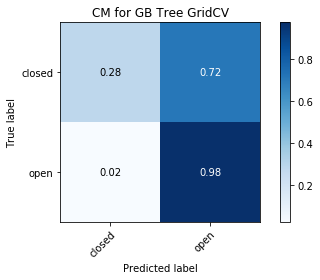

--------------------------------------------------


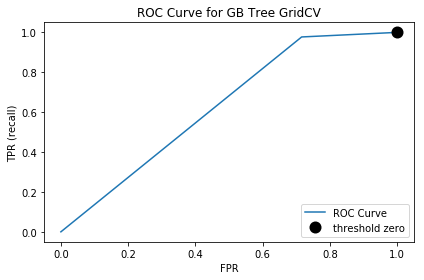

Area Under Curve = 0.6307
--------------------------------------------------


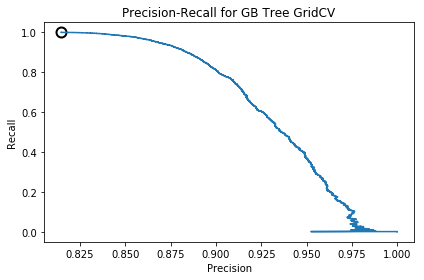

In [6]:
#make pred
y_pred = gbt_cv.predict(X_test)

print(classification_report(y_test, y_pred))
print(50*'-')
plot_help.plot_confusion_matrix(y_test, y_pred, ['closed', 'open'], normalize=True,
                                title='GB Tree GridCV')
print(50*'-')
plot_help.plot_roc_curve(y_test, y_pred, 'GB Tree GridCV')
print(50*'-')
plot_help.plot_prc_curve(y_test, gbt_cv.predict_proba(X_test)[:, 1], 'GB Tree GridCV')